In [12]:
test_df = pd.read_csv('data/ETTh1/test.csv')
input_field = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
output_field = ['OT']
for col in output_field:
    test_df[col+'_pred'] = pd.Series()

In [10]:
test_df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,OT_pred
0,2018-03-09 23:00:00,12.592,3.885,9.879,2.665,2.467,0.640,4.784,NaN
1,2018-03-10 00:00:00,12.458,3.751,10.270,2.594,2.102,0.457,4.854,NaN
2,2018-03-10 01:00:00,12.123,4.488,10.554,3.518,1.858,0.426,5.065,NaN
3,2018-03-10 02:00:00,11.721,3.081,9.879,2.168,1.858,0.487,4.643,NaN
4,2018-03-10 03:00:00,12.391,3.751,10.518,2.630,1.919,0.579,4.784,NaN


In [4]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster

input_field = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
output_field = ['OT']
timeseries_field = input_field + output_field
datasetPath = 'data/ETTh1'

if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')

train_df = pd.read_csv(f'{datasetPath}/train.csv')
test_df = pd.read_csv(f'{datasetPath}/test.csv')
val_df = pd.read_csv(f'{datasetPath}/val.csv')
scaler = Scaler(train_df[timeseries_field], 'minmax')

train_dataset = TimeSeriesDataset(train_df, input_field, output_field, seq_len=64, scaler=scaler)
val_dataset = TimeSeriesDataset(val_df, input_field, output_field, seq_len=64, scaler=scaler)
test_dataset = TimeSeriesDataset(test_df, input_field, output_field, seq_len=64, scaler=scaler)

model = LSTMForecaster(len(input_field), 64, 16, len(output_field), dropout=0.2)
model.to(device)
criterion = torch.nn.MSELoss()

load_checkpoint('out/LSTMForecaster_ETTh1/SeqLen64/best.pth.tar', model)

test_dataset.predict(model)

=> loaded checkpoint 'True' (epoch 25)
Checkpoint's train loss is: 0.0918
Checkpoint's validation loss is: 0.0019


,HUFL,HULL,LUFL,LULL,MUFL,MULL,OT,date,OT_pred
0,0.744575,0.581103,0.377349,0.455286,0.810137,0.636821,0.176972,NaN,NaN
1,0.741478,0.572091,0.339665,0.413856,0.820086,0.631563,0.178370,NaN,NaN
2,0.733735,0.621654,0.314474,0.406837,0.827312,0.699993,0.182582,NaN,NaN
3,0.724445,0.527034,0.314474,0.420648,0.810137,0.600015,0.174157,NaN,NaN
4,0.739929,0.572091,0.320772,0.441476,0.826396,0.634229,0.176972,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2608,0.414870,0.558574,0.481107,0.655196,0.415908,0.597349,0.299159,NaN,0.155502
2609,0.326631,0.608137,0.487404,0.689608,0.326421,0.607865,0.301955,NaN,0.155502
2610,0.518570,0.576597,0.506298,0.655196,0.537988,0.594757,0.286521,NaN,0.155502
2611,0.667175,0.576597,0.500000,0.634594,0.698005,0.594757,0.276679,NaN,0.155502


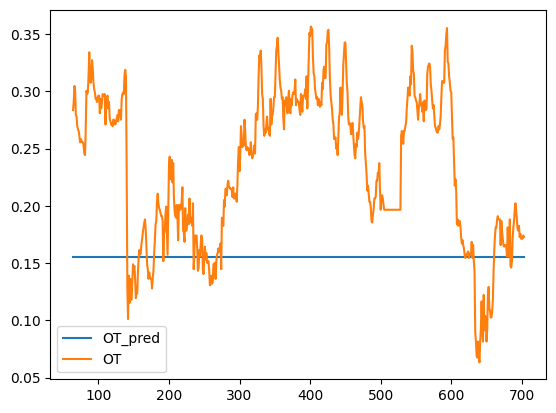

In [5]:
test_dataset.plot_forecast_result()

In [16]:
test_dataset.data

,HUFL,HULL,LUFL,LULL,MUFL,MULL,OT,date,OT_pred
0,0.744575,0.581103,0.377349,0.455286,0.810137,0.636821,0.176972,NaN,NaN
1,0.741478,0.572091,0.339665,0.413856,0.820086,0.631563,0.178370,NaN,NaN
2,0.733735,0.621654,0.314474,0.406837,0.827312,0.699993,0.182582,NaN,NaN
3,0.724445,0.527034,0.314474,0.420648,0.810137,0.600015,0.174157,NaN,NaN
4,0.739929,0.572091,0.320772,0.441476,0.826396,0.634229,0.176972,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2608,0.414870,0.558574,0.481107,0.655196,0.415908,0.597349,0.299159,NaN,0.15706
2609,0.326631,0.608137,0.487404,0.689608,0.326421,0.607865,0.301955,NaN,0.155568
2610,0.518570,0.576597,0.506298,0.655196,0.537988,0.594757,0.286521,NaN,0.15485
2611,0.667175,0.576597,0.500000,0.634594,0.698005,0.594757,0.276679,NaN,0.155238


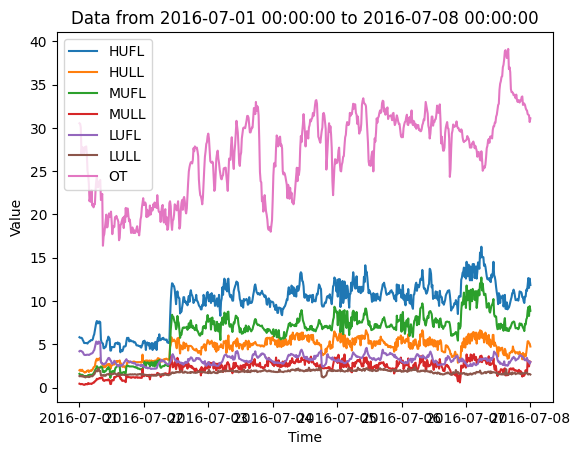

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path, parse_dates=['date'], index_col=['date'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/ETTm1.csv', '2016-07-01 00:00:00', '2016-07-08 00:00:00')